<a href="https://colab.research.google.com/github/ahoucbvtw/RegiFamily_shiny/blob/master/RegiFamily_shiny(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 解壓縮圖片所在的zip檔
# unzip the file

import zipfile
path = "./377.zip"

f = zipfile.ZipFile(path)
f.extractall("pokemon")

In [2]:
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 建立答案的數字轉換
# model's number answer translate

trans = ["沒閃","閃"]
trans_Eng = ["NotShiny", "Shiny"]

In [ ]:
# shutil.rmtree("./pokemon")

In [4]:
path_text = path.split("/")[-1][:3]

path_Train = f"./pokemon/{path_text}/Train"
path_Test = f"./pokemon/{path_text}/Validation"

print(path_Train)
print(path_Test)

./pokemon/377/Train
./pokemon/377/Validation


In [78]:
# 圖片預處理(製作Python產生器)
# Picture preprocess(Make a Generator)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 製作一產生器將圖片Normalize並增加圖片數量
# Picture Normalize and use ImageDataGenerator to add more picture
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   zoom_range = 0.6,
                                   rotation_range = 60,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   fill_mode = "nearest")

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
        path_Train,
        target_size = (300, 300),
        batch_size = 20,
        class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
        path_Test,
        target_size = (300, 300),
        batch_size = 20,
        class_mode = 'categorical')

Found 1834 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [79]:
# 顯示generator內部自行標記的Label編號
# show the label in generator

label_map_train = (train_generator.class_indices)
label_map_test = (test_generator.class_indices)
print(label_map_train)
print(label_map_test)

{'377': 0, '377s': 1}
{'377': 0, '377s': 1}


In [88]:
# 建立CNN網路層
# Build the Self CNN(Convolutional Neural Network)

from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential

layers = [
          Conv2D(50, 3, padding = "same", activation = "relu", input_shape = (300, 300, 3)),
          Conv2D(50, 3, padding = "same", activation = "relu"),
          MaxPooling2D(),
          Conv2D(100, 3, padding = "same", activation = "relu"),
          Conv2D(100, 3, padding = "same", activation = "relu"),
          MaxPooling2D(),
          Conv2D(200, 3, padding = "same", activation = "relu"),
          Conv2D(200, 3, padding = "same", activation = "relu"),
          MaxPooling2D(),
          Conv2D(400, 3, padding = "same", activation = "relu"),
          Conv2D(400, 3, padding = "same", activation = "relu"),
          MaxPooling2D(),
          BatchNormalization(),
          GlobalAveragePooling2D(),
          Dense(100, activation="relu"),
          Dropout(0.35),
          Dense(2, activation="softmax")
]
self_model = Sequential(layers)
self_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          (None, 300, 300, 50)      1400      
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 300, 300, 50)      22550     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 150, 150, 50)      0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 150, 150, 100)     45100     
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 150, 150, 100)     90100     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 75, 75, 100)       0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 75, 75, 200)     

In [61]:
# Use VGG16 this model for Transfer Learning

from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top = False, input_shape = (224,224,3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [66]:
# Use VGG16 this model for Transfer Learning(Add MLP Layer)

from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

mlp = [
          BatchNormalization(),
          GlobalAveragePooling2D(),
          Dense(100, activation="relu"),
          Dropout(0.35),
          Dense(2, activation="softmax")
]

for l in vgg.layers:
    l.trainable = False

layers = vgg.layers + mlp
model = Sequential(layers)
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     

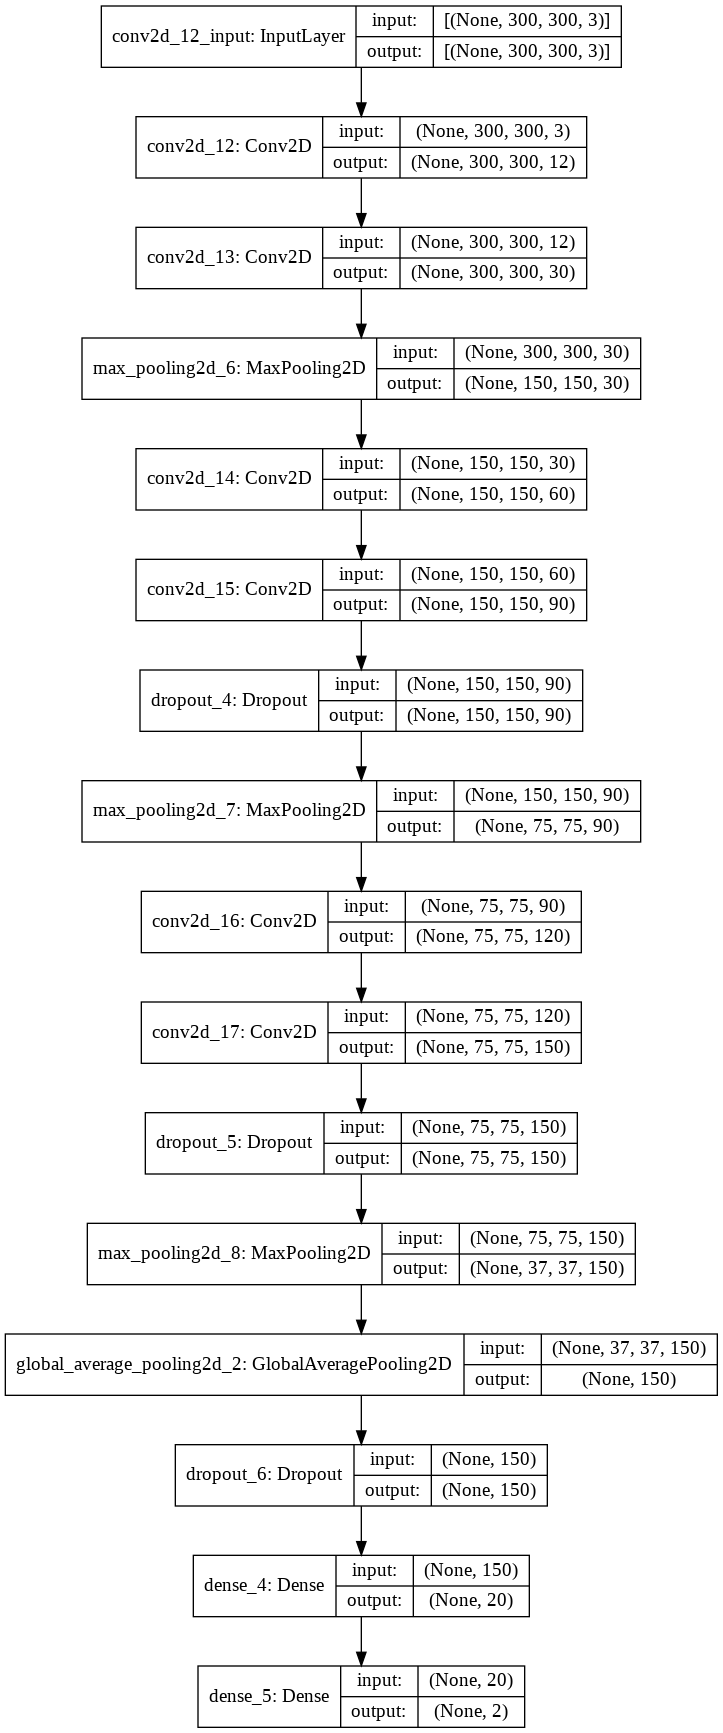

In [19]:
# 畫model的流程圖

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [67]:
# model comple(VGG16 Transfer Learning)
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [89]:
# model comple(Self model)
self_model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [68]:
# Training(VGG16 Transfer Learning)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ReduceLROnPlateau 訓練到一定程度所指定的參數若未沒有甚麼變化，則減少其學習參數的效率
# ReduceLROnPlateau = Reduce learning rate when a metric has stopped improving.

callbacks = [
    ModelCheckpoint("./377.h5", save_best_only = True),
    ReduceLROnPlateau(monitor = "val_loss", factor = 0.25, verbose = 1, patience = 7, min_lr = 0.001),
    EarlyStopping(patience = 8, restore_best_weights = True)
]

# history = model.fit_generator(train_generator,
#                     steps_per_epoch = 92,
#                     epochs = 150,
#                     verbose = 2,
#                     validation_data = test_generator,
#                     validation_steps = 25,
#                     callbacks = callbacks)


history = model.fit(x = train_generator,
                 steps_per_epoch = 92,
                 epochs = 150,
                 verbose = 2,
                 validation_data = test_generator,
                 validation_steps = 25,
                 callbacks = callbacks)

Epoch 1/150
92/92 - 52s - loss: 0.2391 - accuracy: 0.9084 - val_loss: 0.2740 - val_accuracy: 0.8780
Epoch 2/150
92/92 - 50s - loss: 0.0951 - accuracy: 0.9684 - val_loss: 0.0915 - val_accuracy: 0.9520
Epoch 3/150
92/92 - 49s - loss: 0.0679 - accuracy: 0.9755 - val_loss: 0.0192 - val_accuracy: 1.0000
Epoch 4/150
92/92 - 50s - loss: 0.0576 - accuracy: 0.9804 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 5/150
92/92 - 50s - loss: 0.0514 - accuracy: 0.9847 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 6/150
92/92 - 49s - loss: 0.0605 - accuracy: 0.9798 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 7/150
92/92 - 50s - loss: 0.0418 - accuracy: 0.9836 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 8/150
92/92 - 49s - loss: 0.0442 - accuracy: 0.9826 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 9/150
92/92 - 50s - loss: 0.0409 - accuracy: 0.9842 - val_loss: 3.1536e-04 - val_accuracy: 1.0000
Epoch 10/150
92/92 - 50s - loss: 0.0316 - accuracy: 0.9891 - val_loss: 4.8991e-04 - val_accuracy

In [91]:
# Training(Self model)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ReduceLROnPlateau 訓練到一定程度所指定的參數若未沒有甚麼變化，則減少其學習參數的效率
# ReduceLROnPlateau = Reduce learning rate when a metric has stopped improving.

self_callbacks = [
    ModelCheckpoint("./self_377.h5", save_best_only = True),
    ReduceLROnPlateau(monitor = "val_loss", factor = 0.25, verbose = 1, patience = 7, min_lr = 0.001),
    EarlyStopping(patience = 8, restore_best_weights = True)
]

# history = model.fit_generator(train_generator,
#                     steps_per_epoch = 92,
#                     epochs = 150,
#                     verbose = 2,
#                     validation_data = test_generator,
#                     validation_steps = 25,
#                     callbacks = callbacks)


self_history = self_model.fit(x = train_generator,
                 steps_per_epoch = 92,
                 epochs = 150,
                 verbose = 2,
                 validation_data = test_generator,
                 validation_steps = 25,
                 callbacks = self_callbacks)

Epoch 1/150
92/92 - 71s - loss: 0.0267 - accuracy: 0.9951 - val_loss: 3.1090e-07 - val_accuracy: 1.0000
Epoch 2/150
92/92 - 72s - loss: 0.0155 - accuracy: 0.9962 - val_loss: 3.7510e-04 - val_accuracy: 1.0000
Epoch 3/150
92/92 - 72s - loss: 0.0237 - accuracy: 0.9929 - val_loss: 0.0785 - val_accuracy: 1.0000
Epoch 4/150
92/92 - 72s - loss: 0.0153 - accuracy: 0.9956 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 5/150
92/92 - 71s - loss: 0.0117 - accuracy: 0.9973 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/150
92/92 - 72s - loss: 0.0123 - accuracy: 0.9978 - val_loss: 6.3285e-06 - val_accuracy: 1.0000
Epoch 7/150
92/92 - 72s - loss: 0.0167 - accuracy: 0.9962 - val_loss: 1.6737e-07 - val_accuracy: 1.0000
Epoch 8/150
92/92 - 71s - loss: 0.0174 - accuracy: 0.9940 - val_loss: 1.7094e-04 - val_accuracy: 1.0000

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 9/150
92/92 - 71s - loss: 0.0180 - accuracy: 0.9945 - val_loss: 8.5950e-07 - val_accuracy: 1.0000
Epoch 1

In [ ]:
# model.save("./379.h5")

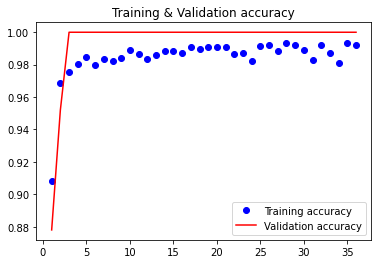

In [85]:
# 顯示隨著時間訓練Training準確率和Validation準確率的變化(VGG16 Transfer Learning)
# Training & Validation accuracy plot(VGG16 Transfer Learning)

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, "bo", label = "Training accuracy")
plt.plot(epochs, val_acc, "r", label = "Validation accuracy")
plt.title("Training & Validation accuracy")
plt.legend()
plt.show()

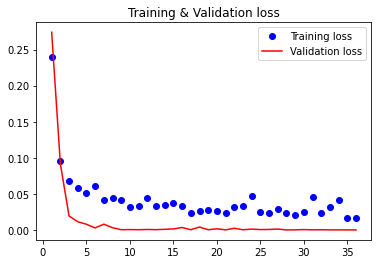

In [86]:
# 顯示隨著時間訓練Training loss和Validation loss的變化(VGG16 Transfer Learning)
# Training & Validation loss plot(VGG16 Transfer Learning)

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) +1)

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "r", label = "Validation loss")
plt.title("Training & Validation loss")
plt.legend()
plt.show()

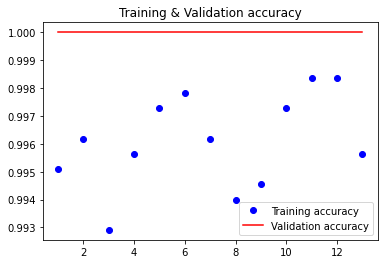

In [93]:
# 顯示隨著時間訓練Training準確率和Validation準確率的變化(Self model)
# Training & Validation accuracy plot(Self model)

self_acc = self_history.history["accuracy"]
self_val_acc = self_history.history["val_accuracy"]

self_epochs = range(1, len(self_acc) +1)

plt.plot(self_epochs, self_acc, "bo", label = "Training accuracy")
plt.plot(self_epochs, self_val_acc, "r", label = "Validation accuracy")
plt.title("Training & Validation accuracy")
plt.legend()
plt.show()

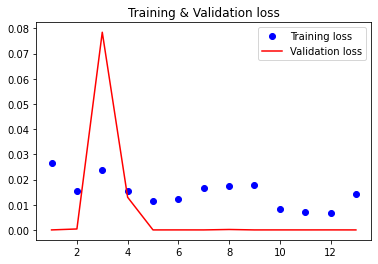

In [94]:
# 顯示隨著時間訓練Training loss和Validation loss的變化(Self model)
# Training & Validation loss plot(Self model)

self_loss = self_history.history["loss"]
self_val_loss = self_history.history["val_loss"]

self_epochs = range(1, len(self_acc) +1)

plt.plot(self_epochs, self_loss, "bo", label = "Training loss")
plt.plot(self_epochs, self_val_loss, "r", label = "Validation loss")
plt.title("Training & Validation loss")
plt.legend()
plt.show()

In [129]:
# Save each epoch's learning_rate、loss、accuracy、val_loss、val_accuracy value to CSV(VGG16 Transfer Learning)

epoch = []
for i in range(1, len(history.history["loss"]) +1):
    epoch.append(i)

history_df = pd.DataFrame({
    "epoch":epoch,
    "learning_rate": history.history["lr"],
    "loss": history.history["loss"],
    "accuracy": history.history["accuracy"],
    "val_loss": history.history["val_loss"],
    "val_accuracy": history.history["val_accuracy"]
})
history_df.to_csv("VGG16_377.csv", index = False)
history_df

,epoch,learning_rate,loss,accuracy,val_loss,val_accuracy
0,1,0.001,0.239138,0.908397,0.273987,0.878
1,2,0.001,0.095101,0.968375,0.091485,0.952
2,3,0.001,0.067942,0.975463,0.019249,1.000
3,4,0.001,0.057620,0.980371,0.011404,1.000
4,5,0.001,0.051414,0.984733,0.007853,1.000
5,6,0.001,0.060508,0.979825,0.002807,1.000
6,7,0.001,0.041837,0.983642,0.007960,1.000
7,8,0.001,0.044174,0.982552,0.003086,1.000
8,9,0.001,0.040860,0.984188,0.000315,1.000
9,10,0.001,0.031601,0.989095,0.000490,1.000


In [134]:
# Save each epoch's learning_rate、loss、accuracy、val_loss、val_accuracy value to CSV(Self model)

self_epoch = []
for i in range(1, len(self_history.history["loss"]) +1):
    self_epoch.append(i)

self_history_df = pd.DataFrame({
    "epoch":self_epoch,
    "learning_rate": self_history.history["lr"],
    "loss": self_history.history["loss"],
    "accuracy": self_history.history["accuracy"],
    "val_loss": self_history.history["val_loss"],
    "val_accuracy": self_history.history["val_accuracy"]
})
self_history_df.to_csv("self_377.csv", index = False)
self_history_df

,epoch,learning_rate,loss,accuracy,val_loss,val_accuracy
0,1,0.001,0.026651,0.995093,3.108976e-07,1.0
1,2,0.001,0.015548,0.996183,3.750982e-04,1.0
2,3,0.001,0.023713,0.992912,7.845123e-02,1.0
3,4,0.001,0.015296,0.995638,1.295882e-02,1.0
4,5,0.001,0.011670,0.997274,0.000000e+00,1.0
5,6,0.001,0.012272,0.997819,6.328524e-06,1.0
6,7,0.001,0.016721,0.996183,1.673698e-07,1.0
7,8,0.001,0.017420,0.994002,1.709355e-04,1.0
8,9,0.001,0.017997,0.994547,8.594972e-07,1.0
9,10,0.001,0.008201,0.997274,5.772697e-06,1.0


[1.0000000e+00 1.8185158e-11]
沒閃 的機率: 1.0
閃 的機率: 0.0
最高機率: 沒閃


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


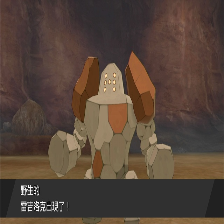

In [145]:
# VGG16 Transfer Learning Test Picture

import cv2
from google.colab.patches import cv2_imshow
import numpy as np

img = cv2.imread("HaveText_NotShinyPicture.jpg", -1)
m1 = cv2.resize(img, (224, 224))
m2 = cv2.cvtColor(m1, cv2.COLOR_BGR2RGB)

test = m2.reshape(1, m2.shape[0], m2.shape[1], m2.shape[2]) / 255

p = model.predict(test)[0]
print(p)
for n, prob in zip(trans, p):
    print(n, "的機率:", round(prob, 3))
ans = model.predict_classes(test)[0]
print("最高機率:", trans[ans])
cv2_imshow(m1)

[0.96439093 0.03560905]
沒閃 的機率: 0.964
閃 的機率: 0.036
最高機率: 沒閃


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


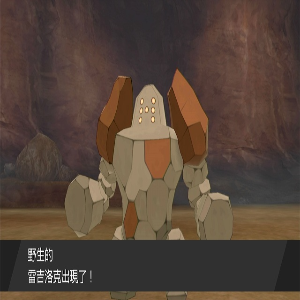

In [146]:
# Self model Test Picture

import cv2
from google.colab.patches import cv2_imshow
import numpy as np

self_img = cv2.imread("HaveText_NotShinyPicture.jpg", -1)
self_m1 = cv2.resize(self_img, (300, 300))
self_m2 = cv2.cvtColor(self_m1, cv2.COLOR_BGR2RGB)

self_test = self_m2.reshape(1, self_m2.shape[0], self_m2.shape[1], self_m2.shape[2]) / 255

self_p = self_model.predict(self_test)[0]
print(self_p)
for n, self_prob in zip(trans, self_p):
    print(n, "的機率:", round(self_prob, 3))
self_ans = self_model.predict_classes(self_test)[0]
print("最高機率:", trans[self_ans])
cv2_imshow(self_m1)